## Imports

In [3]:

import sys
import os
sys.path.append('../src')
#%pip install -r requirements.txt
from data_preprocessing import data_preprocessing_tumor
from model import BrainCNN, EarlyStopping


import torch
import pickle
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchbearer import Trial
from torchmetrics import Precision, Recall, F1Score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [4]:
train_loader, valid_loader, test_loader = data_preprocessing_tumor()
print("data was successfully loaded")

data was successfully loaded


In [5]:

""" 
first try paper CCE, then NLLLoss
cce_loss_fn = nn.NLLLoss()
cce_logits_loss_fn = nn.CrossEntropyLoss()



>>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
>>> optimizer.zero_grad()
>>> loss_fn(model(input), target).backward()
>>> optimizer.step()
    def train(model, train_loader, valid_loader, ):

"""



""" 
important

2 combinations should be tested:
1. last layer Softmax + loss func nn.NLLLoss
2. no last layer and CrossEntropyLoss
"""


num_epochs=50
patience=1
learning_rate=0.001
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = BrainCNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=5, delta=0.01)

train_loss_metr = []
val_loss_metr = []
train_acc_metr = []
val_acc_metr = []
all_targets = []
all_preds = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
        _, predicted = torch.max(output, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
        
    train_loss /= len(train_loader.dataset)
    train_acc = correct_train / total_train
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_targets = []
    val_preds = []
    
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            
            _, predicted = torch.max(output, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()
            
            val_targets.extend(target.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())
    
    val_loss /= len(valid_loader.dataset)
    val_acc = correct_val / total_val
    
    train_loss_metr.append(train_loss)
    val_loss_metr.append(val_loss)
    train_acc_metr.append(train_acc)
    val_acc_metr.append(val_acc)
    all_targets.extend(val_targets)
    all_preds.extend(val_preds)
    
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

accuracy = 100 * correct_val / total_val
precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

with open("training_metrics.pkl", "wb") as f:
    pickle.dump({
        "train_loss": train_loss_metr,
        "val_loss": val_loss_metr,
        "train_acc": train_acc_metr,
        "val_acc": val_acc_metr,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }, f)

torch.save(model.state_dict(), "./braincnn_prototype.weights")


KeyboardInterrupt: 

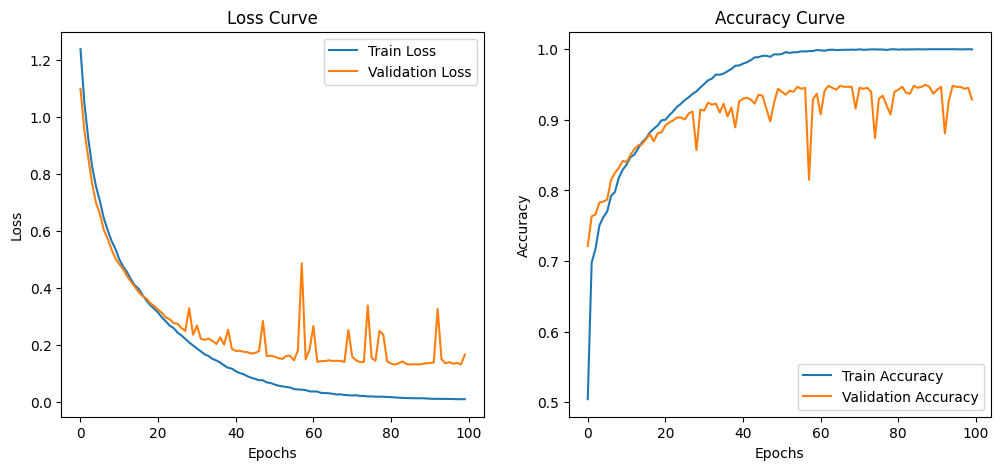

In [6]:
# Load metrics
with open("training_metrics.pkl", "rb") as f:
    metrics = pickle.load(f)

train_loss_metr = metrics["train_loss"]
val_loss_metr = metrics["val_loss"]
train_acc_metr = metrics["train_acc"]
val_acc_metr = metrics["val_acc"]

plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_loss_metr, label='Train Loss')
plt.plot(val_loss_metr, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_acc_metr, label='Train Accuracy')
plt.plot(val_acc_metr, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()
